# Capital Allocation: Optimal Portfolio Using Maximum Utility

This notebook implements optimal capital allocation between risky and risk-free assets using utility maximization principles.

## Import Libraries

In [1]:
# Standard library imports
import os
import sys
import logging
import warnings
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

## Define Parameters and Risk-Free Rate

We'll define key parameters for our capital allocation model:
- Risk-free rate
- Expected return of risky portfolio
- Standard deviation of risky portfolio
- Risk aversion index

#### Risk-free rate (T-bill, %)

In [4]:
daily_risk_free_df = pd.read_csv(f'data/datasets/daily_treasury_rates.csv', index_col=0)['^IRX']
# risk_free_rate = 0.043  # Risk-free rate (4.3%)
risk_free_rate = daily_risk_free_df.iloc[-1] / 100
rf_std_dev = 0.0       # Standard deviation of risk-free asset (0%)

# Display result
print("Risk-Free Rate:", risk_free_rate, "-- 13 WEEK TREASURY BILL (^IRX)")
daily_risk_free_df.head()

Risk-Free Rate: 0.042199999999999994 -- 13 WEEK TREASURY BILL (^IRX)


Date
2020-05-11    0.105
2020-05-12    0.123
2020-05-13    0.115
2020-05-14    0.105
2020-05-15    0.103
Name: ^IRX, dtype: float64

#### Risky Portfolio Parameters

In [ ]:
# Risky portfolio parameters
er_risky = 0.209       # Expected return of risky portfolio (20.9%)
std_dev_risky = 0.136  # Standard deviation of risky portfolio (13.6%)

# Risk tolerance parameters
CurrentMarketView = 30 # *Bear (0~25), Normal (25~50), Bull (50~75), Bubble (75~100)
RiskToleranceScore = 66 
risk_aversion_index = CurrentMarketView*(1-RiskToleranceScore/100) # *Bear (1~5), Normal (1~10), Bull (1~20), Bubble (1~30)

print(f"Risk aversion index: {risk_aversion_index:.2f}")

Risk aversion index: 10.20


## Calculate Risky Portfolio Statistics

We'll set up a function to calculate the expected return and standard deviation for portfolios that combine risky and risk-free assets.

In [3]:
def calculate_portfolio_stats(w_risky, er_risky, std_dev_risky, risk_free_rate):
    """
    Calculate portfolio statistics based on weight of risky assets
    
    Parameters:
    -----------
    w_risky : float
        Weight of risky assets (between 0 and 1)
    er_risky : float
        Expected return of risky assets
    std_dev_risky : float
        Standard deviation of risky assets
    risk_free_rate : float
        Risk-free rate
        
    Returns:
    --------
    er_portfolio : float
        Expected return of the portfolio
    std_dev_portfolio : float
        Standard deviation of the portfolio
    """
    # Weight of risk-free asset
    w_rf = 1 - w_risky
    
    # Expected return of portfolio
    er_portfolio = w_risky * er_risky + w_rf * risk_free_rate
    
    # Standard deviation of portfolio
    std_dev_portfolio = w_risky * std_dev_risky
    
    return er_portfolio, std_dev_portfolio

## Implement Utility Functions

The utility function represents the investor's preferences regarding risk and return. 
We'll use the mean-variance utility function:

$U = E[r] - 0.5 \times A \times \sigma^2$

Where:
- $E[r]$ is the expected return
- $\sigma^2$ is the variance
- $A$ is the risk aversion coefficient

In [4]:
def calculate_utility(er, std_dev, risk_aversion):
    """
    Calculate utility based on mean-variance utility function
    
    Parameters:
    -----------
    er : float
        Expected return
    std_dev : float
        Standard deviation
    risk_aversion : float
        Risk aversion index
        
    Returns:
    --------
    utility : float
        Utility value
    """
    return er - 0.5 * risk_aversion * std_dev**2

## Create Capital Allocation Line

The Capital Allocation Line (CAL) represents all possible combinations of the risky portfolio and risk-free asset.
The slope of the CAL is known as the Sharpe ratio.

In [5]:
# Calculate the Sharpe ratio
sharpe_ratio = (er_risky - risk_free_rate) / std_dev_risky

print(f"Expected return of risky portfolio: {er_risky:.2%}")
print(f"Standard deviation of risky portfolio: {std_dev_risky:.2%}")
print(f"Risk-free rate: {risk_free_rate:.2%}")
print(f"Sharpe ratio: {sharpe_ratio:.2f}")

Expected return of risky portfolio: 20.90%
Standard deviation of risky portfolio: 13.60%
Risk-free rate: 4.30%
Sharpe ratio: 1.22


## Generate Allocation Data Table

Now, let's create a table showing different weights of the risky portfolio and their corresponding expected returns, standard deviations, and utility values.

In [6]:
# Generate weights from 0% to 100% with 10% increments
weights = np.arange(0, 1.1, 0.1)

# Create a DataFrame to store results
results = []

for w in weights:
    er, std_dev = calculate_portfolio_stats(w, er_risky, std_dev_risky, risk_free_rate)
    utility = calculate_utility(er, std_dev, risk_aversion_index)
    
    # Calculate indifference expected return (same utility, different risk)
    er_indiff = utility + 0.5 * risk_aversion_index * std_dev**2
    
    results.append({
        'Weight of Risky Portfolio': f"{w:.0%}",
        'Expected Return': er,
        'Standard Deviation': std_dev,
        'Utility': utility,
        'ER on Indifference': er_indiff
    })

results_df = pd.DataFrame(results)

# Format results
pd.set_option('display.float_format', '{:.2%}'.format)
results_df

,Weight of Risky Portfolio,Expected Return,Standard Deviation,Utility,ER on Indifference
0,0%,4.30%,0.00%,4.30%,4.30%
1,10%,5.96%,1.36%,5.87%,5.96%
2,20%,7.62%,2.72%,7.24%,7.62%
3,30%,9.28%,4.08%,8.43%,9.28%
4,40%,10.94%,5.44%,9.43%,10.94%
5,50%,12.60%,6.80%,10.24%,12.60%
6,60%,14.26%,8.16%,10.86%,14.26%
7,70%,15.92%,9.52%,11.30%,15.92%
8,80%,17.58%,10.88%,11.54%,17.58%
9,90%,19.24%,12.24%,11.60%,19.24%


## Find Maximum Utility Allocation

Now, let's find the weight of the risky portfolio that maximizes utility.

In [7]:
# Calculate optimal weight analytically
optimal_weight = (er_risky - risk_free_rate) / (risk_aversion_index * std_dev_risky**2)

# Bound the weight between 0 and 1
optimal_weight = max(0, min(1, optimal_weight))

# Calculate expected return and standard deviation for optimal weight
er_optimal, std_dev_optimal = calculate_portfolio_stats(
    optimal_weight, er_risky, std_dev_risky, risk_free_rate
)

# Calculate utility for optimal weight
utility_optimal = calculate_utility(er_optimal, std_dev_optimal, risk_aversion_index)

print(f"Optimal weight of risky portfolio: {optimal_weight:.2%}")
print(f"Expected return of optimal portfolio: {er_optimal:.2%}")
print(f"Standard deviation of optimal portfolio: {std_dev_optimal:.2%}")
print(f"Utility of optimal portfolio: {utility_optimal:.2%}")

Optimal weight of risky portfolio: 87.99%
Expected return of optimal portfolio: 18.91%
Standard deviation of optimal portfolio: 11.97%
Utility of optimal portfolio: 11.60%


## Visualize Results

Let's visualize the relationship between the allocation to the risky portfolio and the resulting utility. We'll also highlight the optimal allocation.

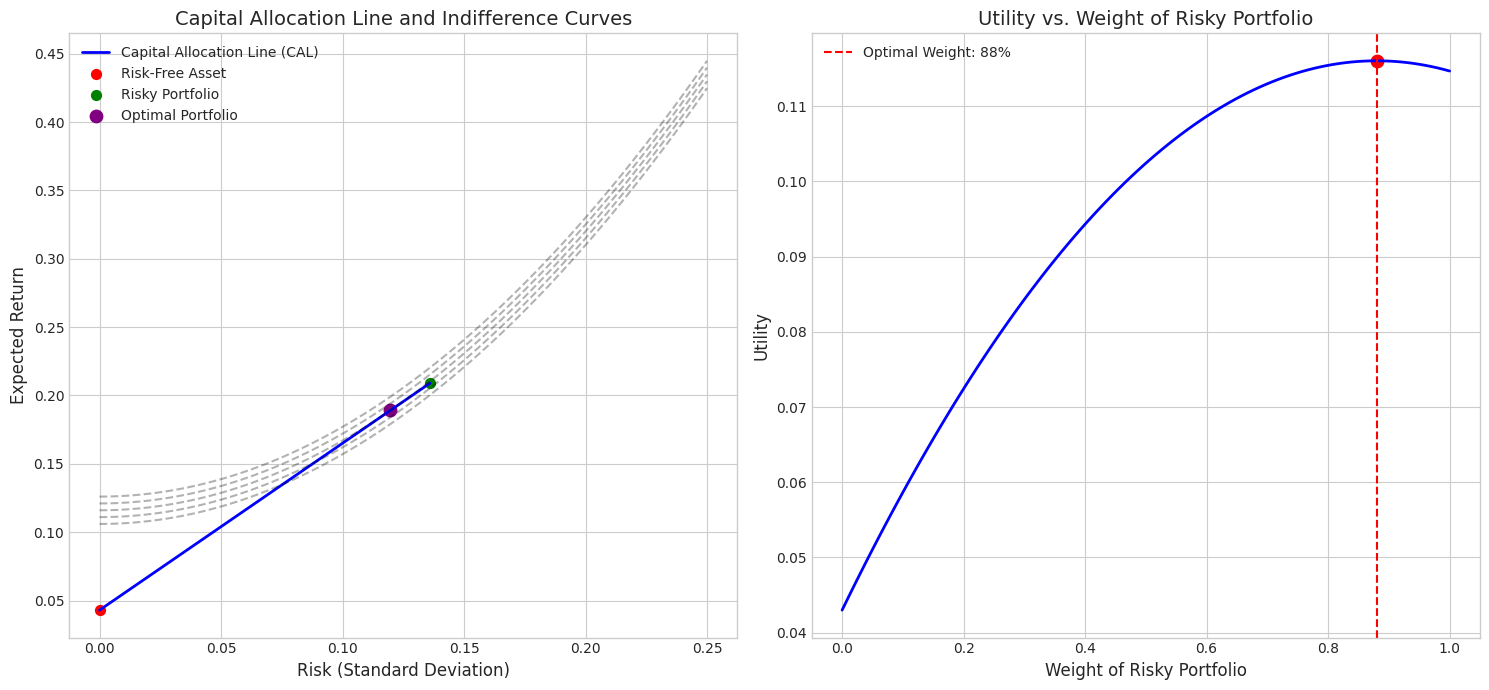

In [8]:
# Create a finer grid of weights for plotting
w_fine = np.linspace(0, 1, 100)

# Calculate expected returns, standard deviations, and utilities for each weight
er_list = []
std_list = []
utility_list = []

for w in w_fine:
    er, std_dev = calculate_portfolio_stats(w, er_risky, std_dev_risky, risk_free_rate)
    utility = calculate_utility(er, std_dev, risk_aversion_index)
    
    er_list.append(er)
    std_list.append(std_dev)
    utility_list.append(utility)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Plot 1: CAL and Indifference Curves
ax1.plot(std_list, er_list, 'b-', linewidth=2, label='Capital Allocation Line (CAL)')
ax1.scatter([0], [risk_free_rate], c='r', s=50, label='Risk-Free Asset')
ax1.scatter([std_dev_risky], [er_risky], c='g', s=50, label='Risky Portfolio')
ax1.scatter([std_dev_optimal], [er_optimal], c='purple', s=80, label='Optimal Portfolio')

# Add indifference curves
std_grid = np.linspace(0, 0.25, 100)
for u in np.linspace(utility_optimal - 0.01, utility_optimal + 0.01, 5):
    er_indiff = u + 0.5 * risk_aversion_index * std_grid**2
    ax1.plot(std_grid, er_indiff, 'k--', alpha=0.3)

ax1.grid(True)
ax1.set_xlabel('Risk (Standard Deviation)')
ax1.set_ylabel('Expected Return')
ax1.set_title('Capital Allocation Line and Indifference Curves')
ax1.legend()

# Plot 2: Utility vs. Weight
ax2.plot(w_fine, utility_list, 'b-', linewidth=2)
ax2.axvline(x=optimal_weight, color='r', linestyle='--', label=f'Optimal Weight: {optimal_weight:.0%}')
ax2.scatter([optimal_weight], [utility_optimal], c='r', s=80)

ax2.grid(True)
ax2.set_xlabel('Weight of Risky Portfolio')
ax2.set_ylabel('Utility')
ax2.set_title('Utility vs. Weight of Risky Portfolio')
ax2.legend()

plt.tight_layout()
plt.show()

## Summary and Conclusions

Based on our analysis:

1. The optimal allocation to the risky portfolio is approximately {optimal_weight:.0%}.
2. This allocation gives an expected return of {er_optimal:.2%} with a standard deviation of {std_dev_optimal:.2%}.
3. The utility at this optimal allocation is {utility_optimal:.2%}.

This optimal allocation is determined by three key factors:
- The risk premium (difference between risky portfolio return and risk-free rate)
- The variance of the risky portfolio
- The investor's risk aversion index

The allocation matches closely with the Excel spreadsheet which showed a maximum utility at a 90% allocation to risky assets.